<a href="https://colab.research.google.com/github/HasithaIndrajith/GAN_MNIST/blob/main/190277L_programmin_assignment_final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> GAN Model Training </h1>

In [ ]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import pickle as pkl

import math
import pickle

import torch.optim as optim

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
print("Available Device:",device.type)

Available Device: cuda


In [ ]:
batch_size=100
z_dim=100

image_channel_size = 1
image_size = 28

epochs = 100
lr = 0.0002

num_workers=2

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_data = datasets.MNIST(root='data', train=True,download=True, transform=transform)


data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=num_workers)

In [ ]:
# Define Generator
class Generator(nn.Module):
    def __init__(self, z_dim, image_size, image_channel_size):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, image_channel_size, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)

In [ ]:
# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, image_channel_size, image_size):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(image_channel_size, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x).view(-1, 1).squeeze(1)

In [ ]:
# Initialize networks
generator = Generator(z_dim, image_size, image_channel_size)
discriminator = Discriminator(image_channel_size, image_size)
generator.to(device)
discriminator.to(device)

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1))
    (9): Sigmoid()
  )
)

In [ ]:
print(generator)
print(discriminator)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)
Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05,

In [ ]:
# Initialize optimizers
optimizer_G = optim.SGD(generator.parameters(), lr=lr)
optimizer_D = optim.SGD(discriminator.parameters(), lr=lr)

In [ ]:
# Loss function
criterion = nn.BCELoss()

In [ ]:
z = torch.randn(batch_size, z_dim, 1, 1).to(device)
generator(z).detach().shape

torch.Size([100, 1, 28, 28])

In [ ]:
noise = torch.randn(batch_size, 100, 1, 1,device=device) # Z Variable
fake_images = generator(noise)
fake_images.view(-1).shape,discriminator(fake_images).view(-1).shape

(torch.Size([78400]), torch.Size([100]))

In [ ]:
z = torch.randn(batch_size, z_dim, 1, 1).to(device)
# generator(z).shape
discriminator(generator(z).detach())

tensor([0.5552, 0.4976, 0.4346, 0.4407, 0.4738, 0.6258, 0.4260, 0.4899, 0.5527,
        0.4948, 0.3121, 0.5038, 0.5023, 0.4169, 0.5464, 0.5665, 0.4479, 0.5975,
        0.4361, 0.5839, 0.3435, 0.4947, 0.5538, 0.3267, 0.4293, 0.4482, 0.4159,
        0.5894, 0.5784, 0.4099, 0.5990, 0.3952, 0.4503, 0.5042, 0.4349, 0.3259,
        0.4700, 0.4764, 0.4032, 0.4871, 0.3354, 0.5096, 0.4684, 0.4467, 0.3905,
        0.4901, 0.5430, 0.3929, 0.4638, 0.4229, 0.4446, 0.5489, 0.4134, 0.4760,
        0.3776, 0.4302, 0.6326, 0.4606, 0.5562, 0.4134, 0.3956, 0.5435, 0.5448,
        0.2836, 0.3961, 0.5167, 0.5084, 0.4276, 0.4440, 0.5752, 0.4985, 0.4164,
        0.5143, 0.5359, 0.4970, 0.6061, 0.5206, 0.6112, 0.6336, 0.4215, 0.5449,
        0.4028, 0.5227, 0.4895, 0.3909, 0.5381, 0.5025, 0.5825, 0.4929, 0.4189,
        0.5299, 0.6731, 0.4010, 0.6406, 0.7296, 0.4720, 0.4733, 0.4424, 0.4432,
        0.5312], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [ ]:
for i, (real_images, _) in enumerate(data_loader):
  print(real_images.shape)
  break

torch.Size([100, 1, 28, 28])


[0/100][0/600] D_loss: 1.5732, G_loss: 0.7201
[0/100][100/600] D_loss: 0.9372, G_loss: 0.8907
[0/100][200/600] D_loss: 0.6965, G_loss: 1.1122
[0/100][300/600] D_loss: 0.5904, G_loss: 1.2000
[0/100][400/600] D_loss: 0.5703, G_loss: 1.2133
[0/100][500/600] D_loss: 0.5813, G_loss: 1.1439
Epoch 0: Discriminator Accuracy on Real Samples: 0.9575
Epoch 0: Discriminator Accuracy on Fake Samples: 0.9216
[1/100][0/600] D_loss: 0.6426, G_loss: 1.0798
[1/100][100/600] D_loss: 0.7276, G_loss: 1.0729
[1/100][200/600] D_loss: 0.7786, G_loss: 1.1115
[1/100][300/600] D_loss: 0.7813, G_loss: 1.0105
[1/100][400/600] D_loss: 0.8762, G_loss: 0.9945
[1/100][500/600] D_loss: 0.8310, G_loss: 1.0262
Epoch 1: Discriminator Accuracy on Real Samples: 0.9589666666666666
Epoch 1: Discriminator Accuracy on Fake Samples: 0.9247666666666666
[2/100][0/600] D_loss: 0.8589, G_loss: 1.1034
[2/100][100/600] D_loss: 0.8865, G_loss: 1.0380
[2/100][200/600] D_loss: 0.9556, G_loss: 1.1297
[2/100][300/600] D_loss: 0.8435, G_los

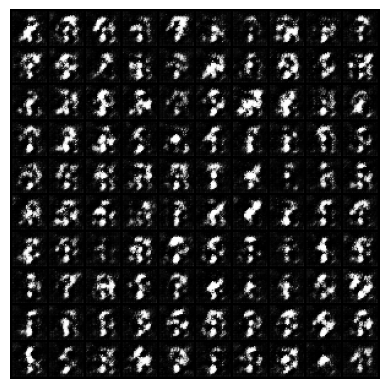

Epoch 9: Discriminator Accuracy on Real Samples: 0.9331833333333334
Epoch 9: Discriminator Accuracy on Fake Samples: 0.9807166666666667
[10/100][0/600] D_loss: 0.4930, G_loss: 1.6447
[10/100][100/600] D_loss: 0.5306, G_loss: 1.9364
[10/100][200/600] D_loss: 0.4039, G_loss: 2.0917
[10/100][300/600] D_loss: 0.4353, G_loss: 1.9901
[10/100][400/600] D_loss: 0.5366, G_loss: 1.9989
[10/100][500/600] D_loss: 0.4841, G_loss: 1.7215
Epoch 10: Discriminator Accuracy on Real Samples: 0.9352833333333334
Epoch 10: Discriminator Accuracy on Fake Samples: 0.9738
[11/100][0/600] D_loss: 0.3309, G_loss: 1.9215
[11/100][100/600] D_loss: 0.4188, G_loss: 2.1013
[11/100][200/600] D_loss: 0.5603, G_loss: 1.6722
[11/100][300/600] D_loss: 0.4840, G_loss: 1.7990
[11/100][400/600] D_loss: 0.3905, G_loss: 1.9382
[11/100][500/600] D_loss: 0.4364, G_loss: 1.9649
Epoch 11: Discriminator Accuracy on Real Samples: 0.94175
Epoch 11: Discriminator Accuracy on Fake Samples: 0.9743333333333334
[12/100][0/600] D_loss: 0.4

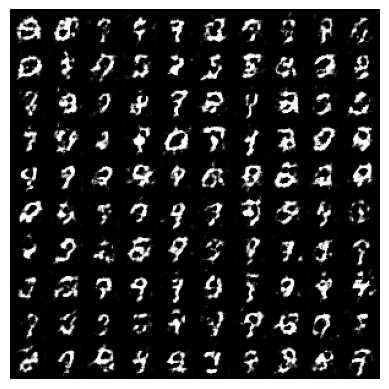

Epoch 19: Discriminator Accuracy on Real Samples: 0.9445833333333333
Epoch 19: Discriminator Accuracy on Fake Samples: 0.9564
[20/100][0/600] D_loss: 0.5808, G_loss: 1.4832
[20/100][100/600] D_loss: 0.3794, G_loss: 1.9541
[20/100][200/600] D_loss: 0.3492, G_loss: 2.1776
[20/100][300/600] D_loss: 0.3871, G_loss: 2.3132
[20/100][400/600] D_loss: 0.5030, G_loss: 1.6375
[20/100][500/600] D_loss: 0.4186, G_loss: 2.6119
Epoch 20: Discriminator Accuracy on Real Samples: 0.9401166666666667
Epoch 20: Discriminator Accuracy on Fake Samples: 0.9522666666666667
[21/100][0/600] D_loss: 0.4652, G_loss: 1.7205
[21/100][100/600] D_loss: 0.4324, G_loss: 1.9795
[21/100][200/600] D_loss: 0.2815, G_loss: 2.3536
[21/100][300/600] D_loss: 0.4136, G_loss: 2.3745
[21/100][400/600] D_loss: 0.4149, G_loss: 1.7326
[21/100][500/600] D_loss: 0.3798, G_loss: 2.2436
Epoch 21: Discriminator Accuracy on Real Samples: 0.9286666666666666
Epoch 21: Discriminator Accuracy on Fake Samples: 0.9434166666666667
[22/100][0/600

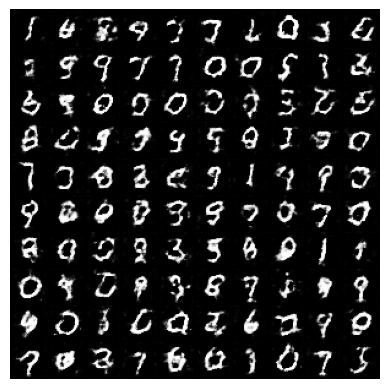

Epoch 29: Discriminator Accuracy on Real Samples: 0.8906666666666667
Epoch 29: Discriminator Accuracy on Fake Samples: 0.9133833333333333
[30/100][0/600] D_loss: 0.5343, G_loss: 1.3973
[30/100][100/600] D_loss: 0.5290, G_loss: 1.4053
[30/100][200/600] D_loss: 0.3815, G_loss: 1.9093
[30/100][300/600] D_loss: 0.4651, G_loss: 2.2174
[30/100][400/600] D_loss: 0.6354, G_loss: 0.8334
[30/100][500/600] D_loss: 0.5437, G_loss: 2.1847
Epoch 30: Discriminator Accuracy on Real Samples: 0.8897333333333334
Epoch 30: Discriminator Accuracy on Fake Samples: 0.9127
[31/100][0/600] D_loss: 0.6048, G_loss: 1.2138
[31/100][100/600] D_loss: 0.4997, G_loss: 1.3002
[31/100][200/600] D_loss: 0.4708, G_loss: 1.9981
[31/100][300/600] D_loss: 0.6405, G_loss: 3.1244
[31/100][400/600] D_loss: 0.5548, G_loss: 1.3525
[31/100][500/600] D_loss: 0.5291, G_loss: 1.7534
Epoch 31: Discriminator Accuracy on Real Samples: 0.8833333333333333
Epoch 31: Discriminator Accuracy on Fake Samples: 0.9027
[32/100][0/600] D_loss: 0.

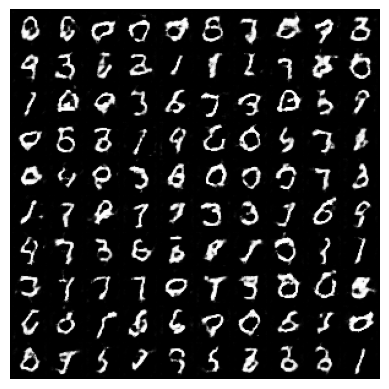

Epoch 39: Discriminator Accuracy on Real Samples: 0.8958166666666667
Epoch 39: Discriminator Accuracy on Fake Samples: 0.9131166666666667
[40/100][0/600] D_loss: 0.9654, G_loss: 1.0214
[40/100][100/600] D_loss: 0.6844, G_loss: 1.0661
[40/100][200/600] D_loss: 0.4377, G_loss: 2.0847
[40/100][300/600] D_loss: 0.4998, G_loss: 2.4688
[40/100][400/600] D_loss: 0.5096, G_loss: 1.9280
[40/100][500/600] D_loss: 0.4550, G_loss: 1.5587
Epoch 40: Discriminator Accuracy on Real Samples: 0.8994833333333333
Epoch 40: Discriminator Accuracy on Fake Samples: 0.9158333333333334
[41/100][0/600] D_loss: 0.8162, G_loss: 1.2188
[41/100][100/600] D_loss: 0.5974, G_loss: 1.1297
[41/100][200/600] D_loss: 0.4092, G_loss: 1.5817
[41/100][300/600] D_loss: 0.3849, G_loss: 2.0766
[41/100][400/600] D_loss: 0.7351, G_loss: 0.8432
[41/100][500/600] D_loss: 0.3808, G_loss: 1.8398
Epoch 41: Discriminator Accuracy on Real Samples: 0.9020166666666667
Epoch 41: Discriminator Accuracy on Fake Samples: 0.9158666666666667
[4

In [ ]:
# Lists to store losses
d_losses = []
g_losses = []
actural_image_d_acc=[]
fake_image_d_acc=[]

# Training loop
for epoch in range(epochs):
    correct_real_predictions = 0
    correct_fake_predictions = 0
    total_real_samples = 0
    total_fake_samples = 0
    for i, (real_images, _) in enumerate(data_loader):
        # Train Discriminator
        discriminator.zero_grad()
        real_images = real_images.to(device)
        real_labels = torch.ones(batch_size, 1).to(device).view(-1)
        fake_labels = torch.zeros(batch_size, 1).to(device).view(-1)

        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_images = generator(z)

        real_output = discriminator(real_images).view(-1)
        fake_output = discriminator(fake_images.detach()).view(-1)

        correct_real_predictions += torch.sum(real_output >= 0.5).item()  # Count correct predictions for real images
        total_real_samples += batch_size

        correct_fake_predictions += torch.sum(fake_output < 0.5).item()  # Count correct predictions for fake images
        total_fake_samples += batch_size


        loss_real = criterion(real_output, real_labels)
        loss_real.backward()

        loss_fake = criterion(fake_output, fake_labels)
        loss_fake.backward()

        optimizer_D.step()

        # Train Generator
        generator.zero_grad()
        z = torch.randn(batch_size, z_dim, 1, 1).to(device)
        fake_images = generator(z)
        output = discriminator(fake_images).view(-1)
        g_loss = criterion(output, real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Append losses to lists
        d_losses.append(loss_fake.item()+loss_real.item())
        g_losses.append(g_loss.item())

        # Print losses
        if i % 100 == 0:
            print('[%d/%d][%d/%d] D_loss: %.4f, G_loss: %.4f'
                  % (epoch, epochs, i, len(data_loader), loss_fake.item()+loss_real.item(), g_loss.item()))
    if((epoch+1) % 10==0): # plotting
      with torch.no_grad():
          fake_samples = generator(torch.randn(100, z_dim, 1, 1).cuda())
          fake_samples = fake_samples.cpu()

          fake_grid = vutils.make_grid(fake_samples, nrow=10, padding=2, normalize=True).cpu()
          plt.imshow(np.transpose(fake_grid, (1, 2, 0)))
          plt.axis('off')
          plt.show()

        # Calculate accuracy for real and fake images
    accuracy_real = correct_real_predictions / total_real_samples
    accuracy_fake = correct_fake_predictions / total_fake_samples
    print("=======================================================================")
    print(f"Epoch {epoch}: Discriminator Accuracy on Real Samples: {accuracy_real}")
    actural_image_d_acc.append(accuracy_real)
    print(f"Epoch {epoch}: Discriminator Accuracy on Fake Samples: {accuracy_fake}")
    fake_image_d_acc.append(accuracy_fake)
    print("=======================================================================")

with open('gan_act_acc.txt', 'w') as file:
  for item in actural_image_d_acc:
    file.write(f"{item}\n")
with open('gan_fake_acc.txt', 'w') as file:
  for item in fake_image_d_acc:
    file.write(f"{item}\n")

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(d_losses, label='Discriminator Loss', alpha=0.5)
plt.plot(g_losses, label='Generator Loss', alpha=0.5)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN Training Losses')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if not torch.cuda.is_available():
    print("CUDA is not available. Loading models on CPU.")
    map_location = torch.device('cpu')
else:
    map_location = None

CUDA is not available. Loading models on CPU.


In [ ]:
import torch
import torch.nn as nn
import pickle


# Save Generator and Discriminator models using pickle
generator_path = "/content/drive/MyDrive/advancedmloutputs/G.pkl"
discriminator_path = "/content/drive/MyDrive/advancedmloutputs/D.pkl"


# with open(generator_path, 'wb') as f:
#     pickle.dump(generator, f)

# with open(discriminator_path, 'wb+') as f:
#     pickle.dump(discriminator, f)

# Load Generator and Discriminator models using pickle
with open(generator_path, 'rb') as f:
    loaded_generator = pickle.load(f)

with open(discriminator_path, 'rb') as f:
    loaded_discriminator = pickle.load(f)



In [ ]:
loaded_generator

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)

In [ ]:
loaded_discriminator

Discriminator(
  (disc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1))
    (9): Sigmoid()
  )
)

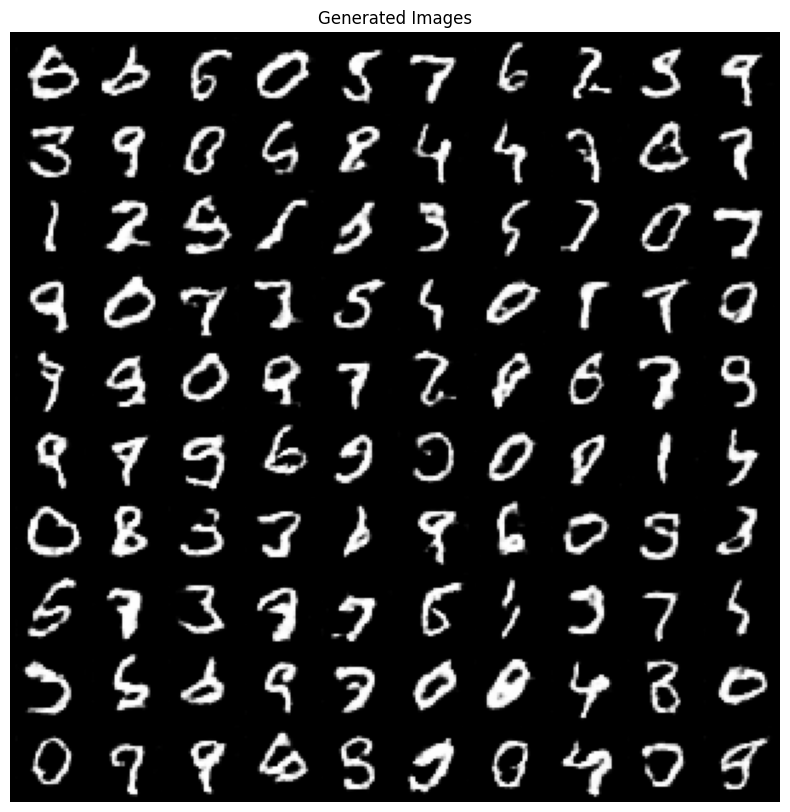

In [ ]:
noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

fake_images = loaded_generator(noise)

# Plot the generated fake images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")

images_to_show = 100
if images_to_show > batch_size:
    print(f"Warning: Requested {images_to_show} images, but the batch size is {batch_size}. Generating and displaying all available images.")

# Display the first 100 generated fake images
plt.imshow(np.transpose(vutils.make_grid(fake_images[:images_to_show], nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

<h1> Data Set </h1>


In [ ]:
save_dir = '/content/drive/MyDrive/advancedmloutputs/fake_images_all'

In [ ]:
# import os
# num_images = 300

# for i in range(600,num_images+600):
#     # Create a subdirectory for each image
#     # sub_dir = os.path.join(save_dir, str(i + 1))
#     # os.makedirs(sub_dir, exist_ok=True)

#     # Generate random noise
#     noise = torch.randn(1, z_dim, 1, 1)
#     noise = noise.to(device)


#     with torch.no_grad():
#         fake_image = loaded_generator(noise)

#     image_path = os.path.join(save_dir, f'{i+1:03d}.png')
#     vutils.save_image(fake_image, image_path, normalize=True)


#     latent_vector_path = os.path.join(save_dir, f'{i+1:03d}.txt')
#     latent_vector_string =  str(noise.squeeze().cpu().numpy().tolist())

#     with open(latent_vector_path, "w") as file:
#       file.write(latent_vector_string)

# print(f'{num_images} images and their latent vectors saved in {save_dir}')


300 images and their latent vectors saved in /content/drive/MyDrive/advancedmloutputs/fake_images_all


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

900


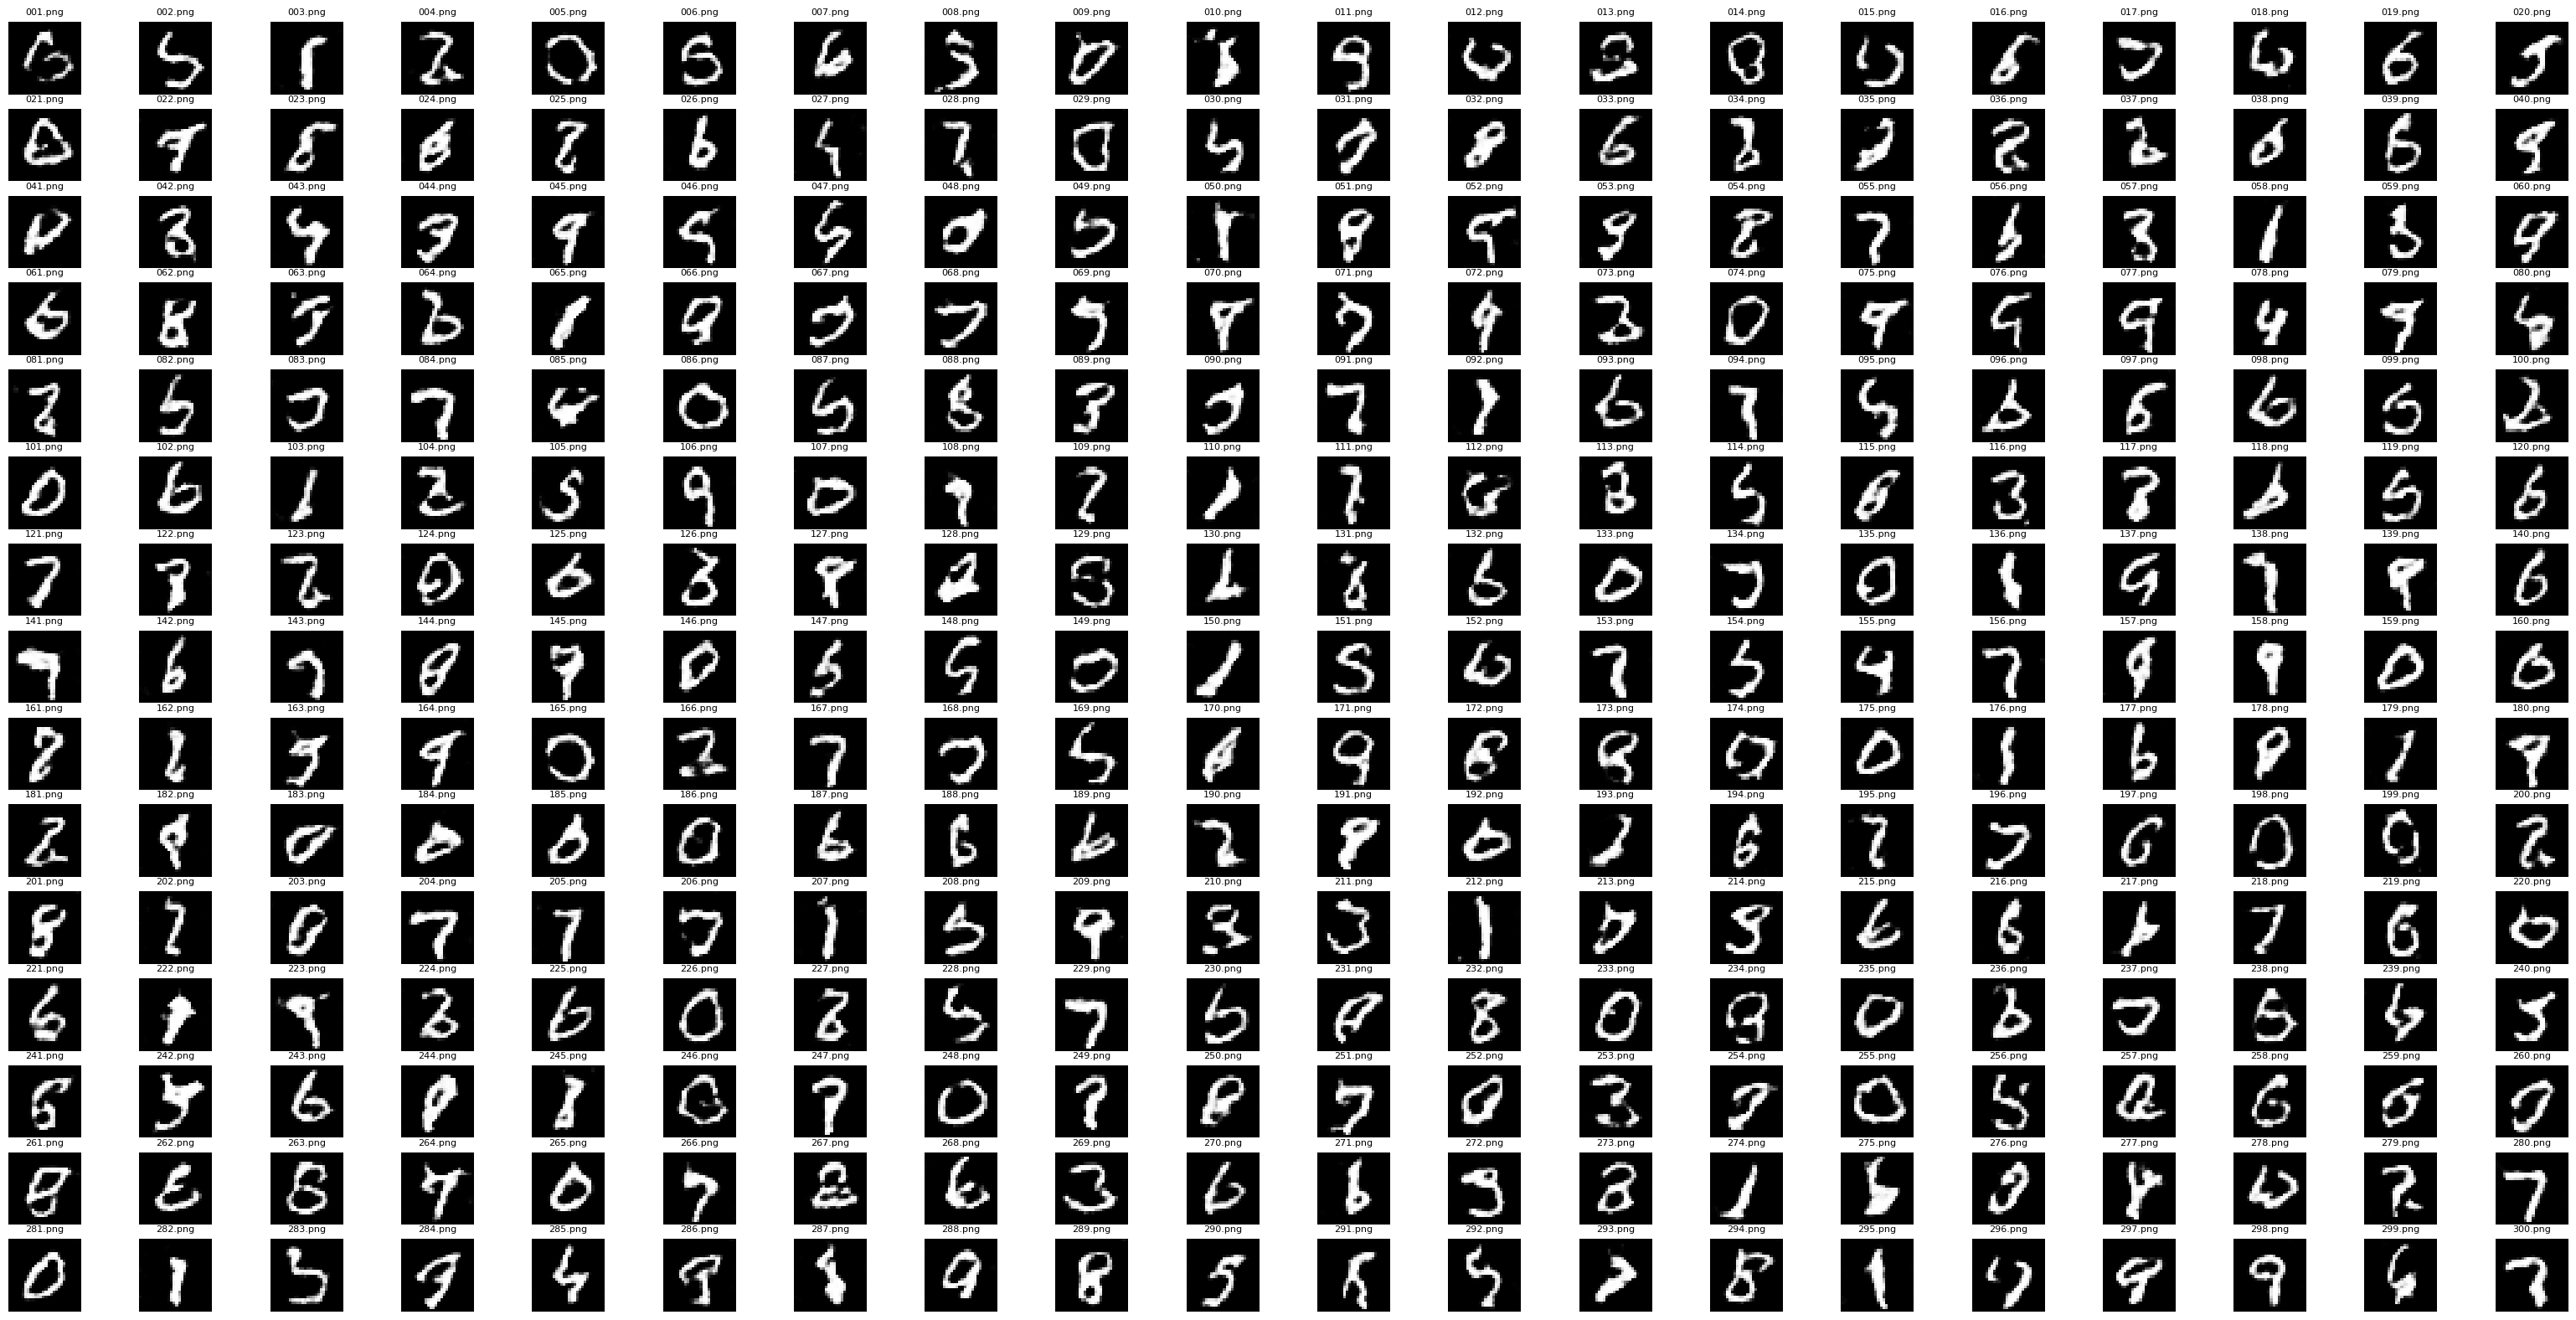

In [ ]:

import os
img_dir = "/content/drive/MyDrive/advancedmloutputs/fake_images_all"

images = [img for img in os.listdir(img_dir) if img.endswith('.png')]
images.sort()
print(len(images))
images = images[0:300]
fig = plt.figure(figsize=(40, 20))


num_images_to_plot = min(300, len(images))
for i in range(300):
    img = mpimg.imread(os.path.join(img_dir, images[i]))
    ax = fig.add_subplot(15, 20, i+1)
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(images[i], fontsize=8)


plt.show()


In [ ]:
selected = {
    0:[5,9,12,174,175,198,199,260,278,252],
    1:[282,162,3,176,212,274,295,207,150,58],
    2:[56,861,877,615,638,743,603,767,877,756],
    3:[284,253,269,116,452,305,357,439,569,553],
    4:[155,416,479,316,347,543,479,416,640,632],
    5:[290,292,151,148,323,352,359,377,385,421],
    6:[140,68,243,302,307,315,327,331,356,360],
    7:[300,280,195,153,156,218,195,229,301,487],
    8:[273,232,62,263,289,328,721,760,718,773],
    9:[298,40,46,288,171,599,556,497,499,393]
}

In [ ]:
total_count = sum(len(values) for values in selected.values())

print(f'Total count: {total_count}')

Total count: 100


In [ ]:
for i in range(10):
  print("COUNT:",i,len(selected[i]))

COUNT: 0 10
COUNT: 1 10
COUNT: 2 10
COUNT: 3 10
COUNT: 4 10
COUNT: 5 10
COUNT: 6 10
COUNT: 7 10
COUNT: 8 10
COUNT: 9 10


In [ ]:
# import os
# import shutil

# source_dir = "/content/drive/MyDrive/advancedmloutputs/fake_images_all"
# destination_base_dir = "/content/drive/MyDrive/advancedmloutputs/Fake_Digits"

# selected = {
#     0:[5,9,12,174,175,198,199,260,278,252],
#     1:[282,162,3,176,212,274,295,207,150,58],
#     2:[56,861,877,615,638,743,603,767,877,756],
#     3:[284,253,269,116,452,305,357,439,569,553],
#     4:[155,416,479,316,347,543,479,416,640,632],
#     5:[290,292,151,148,323,352,359,377,385,421],
#     6:[140,68,243,302,307,315,327,331,356,360],
#     7:[300,280,195,153,156,218,195,229,301,487],
#     8:[273,232,62,263,289,328,721,760,718,773],
#     9:[298,40,46,288,171,599,556,497,499,393]
# }

# for key, indices in selected.items():
#     destination_dir = os.path.join(destination_base_dir, str(key))
#     os.makedirs(destination_dir, exist_ok=True)


#     for index in indices:
#         image_filename = f'{index:03d}.png'
#         txt_filename = f'{index:03d}.txt'

#         source_image_path = os.path.join(source_dir, image_filename)
#         source_txt_path = os.path.join(source_dir, txt_filename)

#         destination_image_path = os.path.join(destination_dir, image_filename)
#         destination_txt_path = os.path.join(destination_dir, txt_filename)

#         shutil.copy(source_image_path, destination_image_path)
#         shutil.copy(source_txt_path, destination_txt_path)

# print(f'Selected images and txt files copied to relevant directories in {destination_base_dir}')

Selected images and txt files copied to relevant directories in /content/drive/MyDrive/advancedmloutputs/selected_images


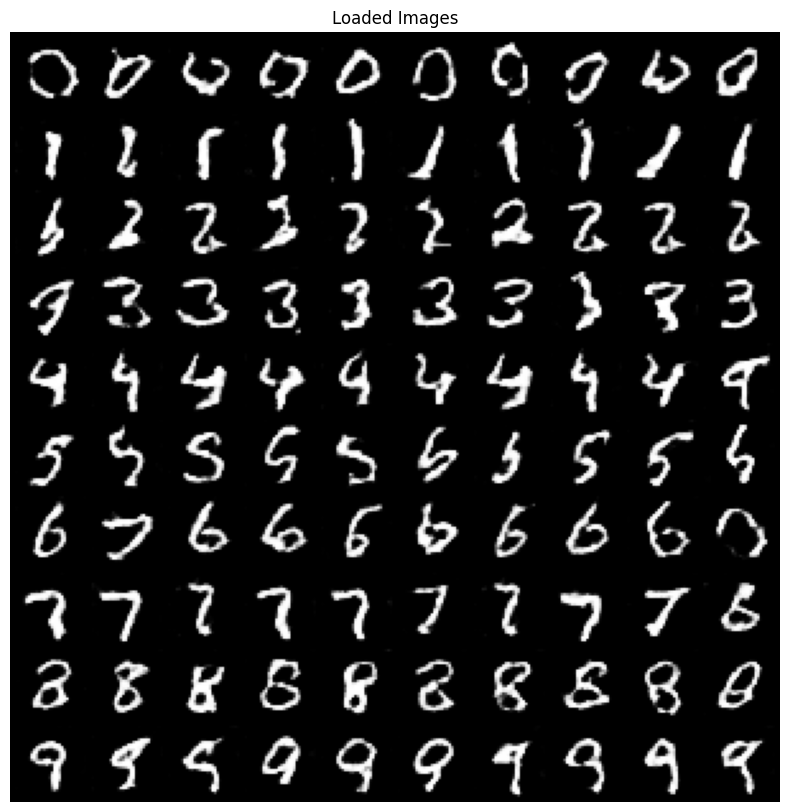

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision.transforms as transforms
import numpy as np

image_dir = "/content/drive/MyDrive/advancedmloutputs/fake_images_all"
# Function to load an image given its file path
def load_image(idx):
    file_path = os.path.join(image_dir, f"{idx:03d}.png")
    return Image.open(file_path).convert('RGB')

# Example paths to the images

selected = {
    0:[5,9,12,174,175,198,199,260,278,252],
    1:[282,162,3,176,212,274,295,207,150,58],
    2:[56,861,877,615,638,743,603,767,877,756],
    3:[284,253,269,116,452,305,357,439,569,553],
    4:[155,416,479,316,347,543,479,416,640,632],
    5:[290,292,151,148,323,352,359,377,385,421],
    6:[140,68,243,302,307,315,327,331,356,360],
    7:[300,280,195,153,156,218,195,229,301,487],
    8:[273,232,62,263,289,328,721,760,718,773],
    9:[298,40,46,288,171,599,556,497,499,393]
}

img_names = []
for i in range(10):
  img_names += selected[i]

images = [transforms.ToTensor()(load_image(name)) for name in img_names]


plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Loaded Images")


images_to_show = min(100, len(images))
if images_to_show > len(images):
    print(f"Warning: Requested {images_to_show} images, but only {len(images)} images are available. Displaying all available images.")

plt.imshow(np.transpose(vutils.make_grid(images[:images_to_show], nrow=10, padding=2, normalize=True), (1, 2, 0)))

plt.show()


<h1> Classifier </h1>

In [ ]:
import torch

from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

import torch.nn as nn

from torch import optim
from torch.autograd import Variable

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
# Define transforms to normalize the data
transform = transforms.Compose([
    transforms.Resize((28, 28)),    # Resize images to 28x28
    transforms.Grayscale(num_output_channels=1),# Convert images to grayscale
    transforms.ToTensor(),          # Convert PIL Image to tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize pixel values to range [-1, 1]
])

# Define path to the folder containing subfolders for each class
data_dir = '/content/drive/MyDrive/advancedmloutputs/Fake_Digits/'

In [ ]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)


# get the training datasets
test_data = datasets.MNIST(root='data', train=False,
                                   download=True, transform=transform)

# prepare data loader
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)



# # Create custom dataset using ImageFolder
custom_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
# # Create DataLoader for the custom dataset
# S1= DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)


# Print the number of classes in the dataset
print("Number of classes:", len(custom_dataset.classes))

# Print the size of the dataset
print("Number of examples:", len(custom_dataset))

# Print the class labels
print("Class labels:", custom_dataset.classes)

100%|██████████| 9912422/9912422 [00:00<00:00, 63061340.60it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30784166.16it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 18894226.18it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5921830.52it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Number of classes: 10
Number of examples: 96
Class labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
import random

random_indices = random.sample(range(len(test_data)), 100)

S0 = torch.utils.data.Subset(test_data, random_indices)
S1 = ImageFolder(root=data_dir, transform=transform)
loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=2),

    'test' : torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=True, num_workers=2),
    'S0' : torch.utils.data.DataLoader(S0,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2),

    'S1'  : torch.utils.data.DataLoader(S1,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
}

In [ ]:
for i in loaders['S0']:
  print(i[0].shape)

torch.Size([100, 1, 28, 28])


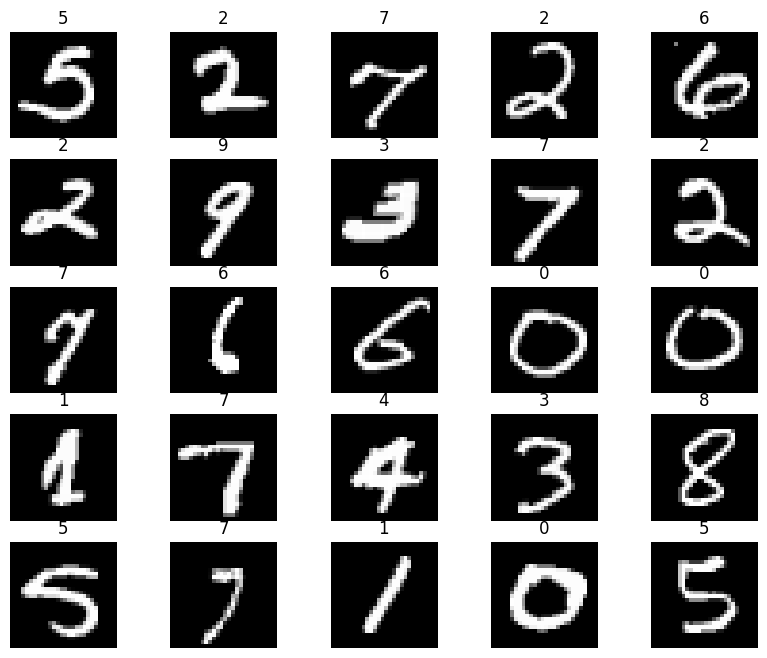

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7af5d2415690>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7af5d2415780>,
 'S0': <torch.utils.data.dataloader.DataLoader at 0x7af5010dbbb0>,
 'S1': <torch.utils.data.dataloader.DataLoader at 0x7af5010da620>}

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=36,  #16
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(36, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization



In [ ]:
cnn=CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(36, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(cnn.parameters(), lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [ ]:
num_epochs = 10

#Remember to run on GPU

def train(num_epochs, cnn, loaders):

    cnn.train()

    # Train the model
    total_step = len(loaders['train'])
    accuracies_epoch = []
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # Calculate training accuracy
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()



            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        train_accuracy = 100 * correct / total
        print("==========================================================================")
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Accuracy: {train_accuracy:.2f}%")
        accuracies_epoch.append(train_accuracy)
        print("==========================================================================")

        pass
    with open('cnn_acc.txt', 'w') as file:
      for item in accuracies_epoch:
        file.write(f"{item}\n")
    pass

train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.0237
Epoch [1/10], Step [200/600], Loss: 0.2422
Epoch [1/10], Step [300/600], Loss: 0.0725
Epoch [1/10], Step [400/600], Loss: 0.1842
Epoch [1/10], Step [500/600], Loss: 0.0754
Epoch [1/10], Step [600/600], Loss: 0.0337
Epoch [1/10], Training Accuracy: 95.65%
Epoch [2/10], Step [100/600], Loss: 0.0878
Epoch [2/10], Step [200/600], Loss: 0.1058
Epoch [2/10], Step [300/600], Loss: 0.0083
Epoch [2/10], Step [400/600], Loss: 0.0944
Epoch [2/10], Step [500/600], Loss: 0.0283
Epoch [2/10], Step [600/600], Loss: 0.1098
Epoch [2/10], Training Accuracy: 97.89%
Epoch [3/10], Step [100/600], Loss: 0.0468
Epoch [3/10], Step [200/600], Loss: 0.0559
Epoch [3/10], Step [300/600], Loss: 0.1236
Epoch [3/10], Step [400/600], Loss: 0.0632
Epoch [3/10], Step [500/600], Loss: 0.0278
Epoch [3/10], Step [600/600], Loss: 0.0453
Epoch [3/10], Training Accuracy: 98.05%
Epoch [4/10], Step [100/600], Loss: 0.0249
Epoch [4/10], Step [200/600], Loss: 0.0111
Epoch [4/10], Step [

In [ ]:
cnn

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(36, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [ ]:
def test(loader_):
  cnn.eval()
  with torch.no_grad():
    correct=0
    total=0
    for images, labels in loaders[loader_]:
      test_output,last_layer=cnn(images)
      pred_y=torch.max(test_output,1)[1].data.squeeze()
      accuracy=(pred_y==labels).sum().item()/float(labels.size(0))
      pass
    print('Test Acc %.2f' % accuracy)
    pass


test("test")

Test Acc 0.97


In [ ]:
sample = next(iter(loaders['S1']))
imgs, lbls = sample
actual_number = lbls[:100].numpy()

In [ ]:
lbls

tensor([7, 2, 3, 5, 1, 8, 5, 7, 7, 0, 7, 0, 1, 4, 1, 4, 9, 5, 5, 7, 1, 7, 0, 4,
        7, 2, 9, 9, 2, 3, 0, 9, 3, 4, 1, 2, 3, 6, 7, 6, 9, 9, 5, 8, 0, 3, 6, 1,
        2, 4, 2, 8, 3, 6, 6, 4, 8, 7, 8, 9, 4, 8, 9, 3, 8, 8, 6, 0, 0, 3, 0, 3,
        5, 6, 2, 9, 4, 3, 6, 0, 5, 2, 1, 6, 1, 5, 0, 5, 9, 8, 1, 6, 8, 2, 5, 1])

In [ ]:
test_output,last_layer=cnn(imgs[:100])
pred_y=torch.max(test_output,1)[1].data.numpy().squeeze()

print(f'Prediction number {pred_y}')
print(f'Actual number {actual_number}')

Prediction number [2 2 3 5 1 8 5 1 7 0 6 0 1 4 1 4 9 6 5 3 1 7 0 4 2 2 9 9 1 3 3 9 3 9 0 2 3
 6 7 6 9 9 5 8 0 3 6 1 4 4 2 5 3 6 0 4 8 7 8 9 4 8 9 3 2 0 3 0 0 3 3 3 5 6
 3 9 4 3 6 0 3 2 1 6 1 5 0 5 5 8 1 6 8 3 5 1]
Actual number [7 2 3 5 1 8 5 7 7 0 7 0 1 4 1 4 9 5 5 7 1 7 0 4 7 2 9 9 2 3 0 9 3 4 1 2 3
 6 7 6 9 9 5 8 0 3 6 1 2 4 2 8 3 6 6 4 8 7 8 9 4 8 9 3 8 8 6 0 0 3 0 3 5 6
 2 9 4 3 6 0 5 2 1 6 1 5 0 5 9 8 1 6 8 2 5 1]


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm=confusion_matrix(actual_number, pred_y)

Confusion matrix, without normalization
[[ 8  0  0  2  0  0  0  0  0  0]
 [ 1  9  0  0  0  0  0  0  0  0]
 [ 0  1  5  2  1  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  1]
 [ 0  0  0  1  0  8  1  0  0  0]
 [ 1  0  0  1  0  0  8  0  0  0]
 [ 0  1  2  1  0  0  1  4  0  0]
 [ 1  0  1  0  0  1  0  0  7  0]
 [ 0  0  0  0  0  1  0  0  0  9]]


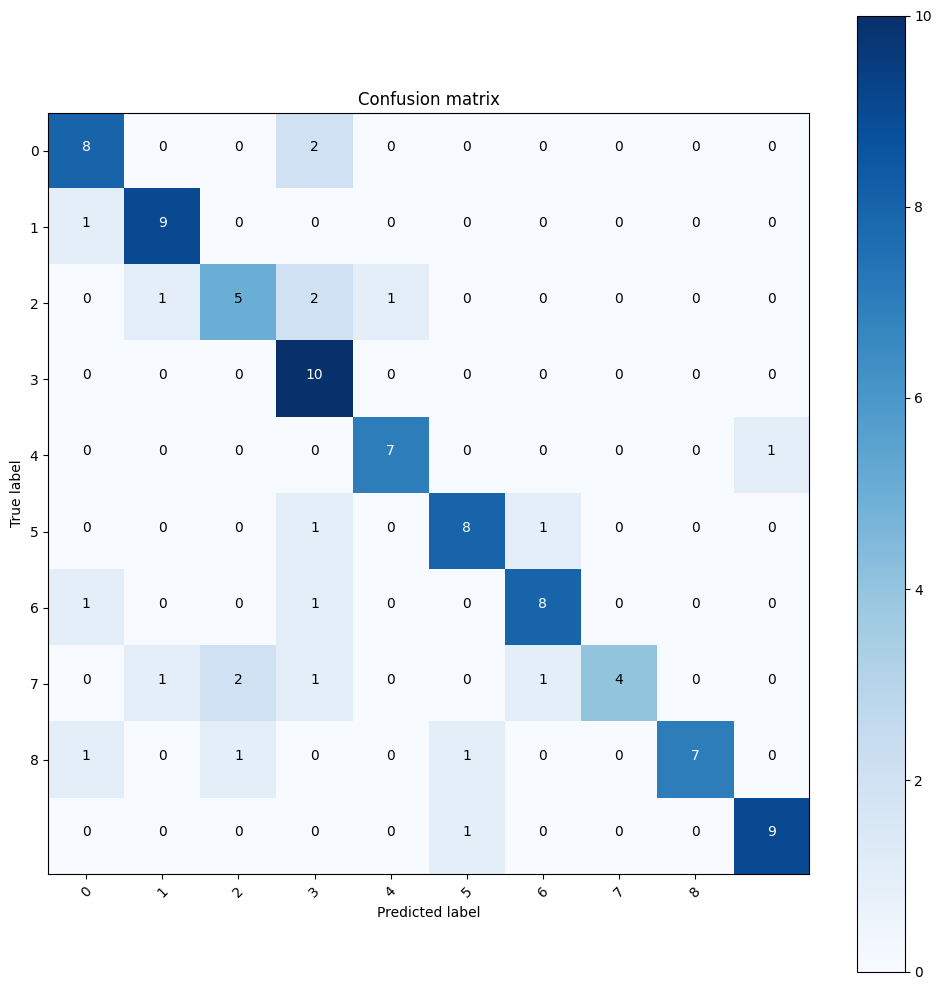

In [ ]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, [str(i) for i in range(0,9)])

In [ ]:
cnn

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 36, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(36, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)

In [ ]:
# import pickle

# with open('/content/drive/MyDrive/advancedmloutputs/C.pkl', 'wb') as f:
#     pickle.dump(cnn, f)